# Purpose of this notebook

This notebook is to test isopycnal and diapycnal mixing with advection and diffusion. This will attempt to take a cross section in x and y and look at the advection and diffusion terms across the density surfaces. We need
- theta
- salt
- adv in x y r
- df in x y r

# Import packages and functions

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# read the grid

In [3]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [4]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
# hFacCpartial = mygrid['hFacC']
# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
print(hf1.shape)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)


In [5]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

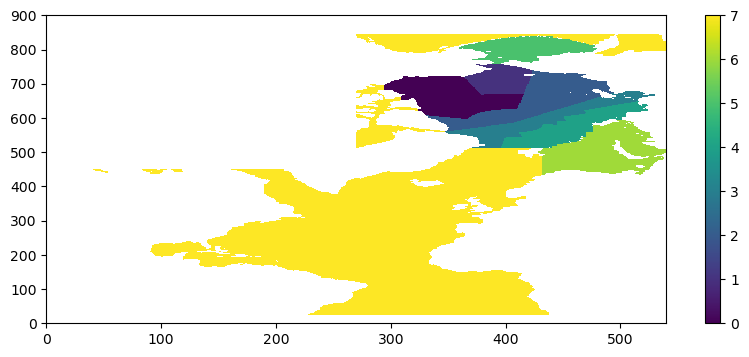

In [6]:
plt.pcolormesh(get_aste_tracer(mskBasin,nfx,nfy)[0],vmax=7)
plt.colorbar()

In [7]:
# Copy mskBasin to mymsk
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
mask = mymsk < 7

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [8]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

# load the gateways
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    #mskBasin = (inf["mskBasin"])
    ggate  = inf['ggate']
    ggate2  = inf['ggate2']
    
num = 1
for i in ggate[0]:
    label = i[0][0][0]
    # print(num,label)
    num += 1
print()

num = 1
for i in ggate2[0]:
    label = (i[0][0][-2])
    # print(num,label)
    num += 1

# we have to first make a dictionary
gg = {}
ggate1 = ggate[0]
for mygate in ggate1:
    name = mygate[0][0][0][0]
    gg[name] = {}
    gg[name]['ix'] = mygate[0][0][1][0]
    gg[name]['jy'] = mygate[0][0][2][0]
    gg[name]['signu'] = mygate[0][0][3][0]
    gg[name]['signv'] = mygate[0][0][4][0]
    gg[name]['descr'] = mygate[0][0][5][0]

gg2 = {}
ggate2a = ggate2[0]
for mygate in ggate2a:
    name = mygate[0][0][4][0]
    gg2[name] = {}
    gg2[name]['ix'] = mygate[0][0][0][0]
    gg2[name]['jy'] = mygate[0][0][1][0]
    gg2[name]['signu'] = mygate[0][0][2][0]
    gg2[name]['signv'] = mygate[0][0][3][0]
    gg2[name]['descr'] = mygate[0][0][5][0]

# check with An to see if these are the same values
for igate in gg.keys():
    L = len(gg[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg[igate]['jy'][i] - 1) * nx + gg[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg[igate]['indwet'] = indwet
    gg[igate]['ivalid'] = ivalid

# check with An to see if these are the same values
for igate in gg2.keys():
    L = len(gg2[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg2[igate]['jy'][i] - 1) * nx + gg2[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg2[igate]['indwet'] = indwet
    gg2[igate]['ivalid'] = ivalid

LwetC2d 146614
LwetC 4833023



# Load the files

In [9]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.array([1,2,3,4,5,6,7,8,9]) #,5,6,7,8,9,10,11,12])
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [10]:
# we want temperature and salt
THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)

for i in range(len(tsstr)):

    # read the fldList
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR","SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
    read = [int(tsstr[i])]
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m

    THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
    SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [11]:
# get velocity fields
# read timesteps at index 1 and 3
UVELMASS = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
VVELMASS = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
ADVx_TH = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
ADVy_TH = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFxE_TH = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFyE_TH = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
ADVx_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
ADVy_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFxE_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFyE_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)


meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
varnames = np.array(['UVELMASS','VVELMASS','ADVx_TH','ADVy_TH','DFxE_TH','DFyE_TH','ADVx_SLT','ADVy_SLT','DFxE_SLT','DFyE_SLT'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# read the averages from tsstr[1] and tsstr[3] - averages from March and September
# start from 1 because these are averages
for i in range(0,len(tsstr)):

    UVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[0])     # m/s
    VVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[1])     # m/s
    ADVx_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[2])        # degC.m^3/s
    ADVy_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[3])        # degC.m^3/s
    DFxE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[4])        # degC.m^3/s
    DFyE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[5])        # degC.m^3/s
    ADVx_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[6])       # psu.m^3/s
    ADVy_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[7])       # psu.m^3/s
    DFxE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[8])       # psu.m^3/s
    DFyE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[9])       # psu.m^3/s
    
    # reshaping and fixing up
    UVELMASS[i,:,:,:] = UVELMASSi.reshape(nz,ny,nx)
    VVELMASS[i,:,:,:] = VVELMASSi.reshape(nz,ny,nx)
    ADVx_TH[i,:,:,:] = ADVx_THi.reshape(nz,ny,nx)
    ADVy_TH[i,:,:,:] = ADVy_THi.reshape(nz,ny,nx)
    DFxE_TH[i,:,:,:] = DFxE_THi.reshape(nz,ny,nx)
    DFyE_TH[i,:,:,:] = DFyE_THi.reshape(nz,ny,nx)
    ADVx_SLT[i,:,:,:] = ADVx_SLTi.reshape(nz,ny,nx)
    ADVy_SLT[i,:,:,:] = ADVy_SLTi.reshape(nz,ny,nx)
    DFxE_SLT[i,:,:,:] = DFxE_SLTi.reshape(nz,ny,nx)
    DFyE_SLT[i,:,:,:] = DFyE_SLTi.reshape(nz,ny,nx)

# get the vectors of u and v without mass weighting
Uo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
Vo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVx_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVx_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)

for i in range((int(len(tsstr)))):
    # get values from reading before
    tmpU = UVELMASS[i]
    tmpV = VVELMASS[i]
    tmpUadvth = ADVx_TH[i]
    tmpVadvth = ADVy_TH[i]
    tmpUdfth = DFxE_TH[i]
    tmpVdfth = DFyE_TH[i]
    tmpUadvslt = ADVx_SLT[i]
    tmpVadvslt = ADVy_SLT[i]
    tmpUdfslt = DFxE_SLT[i]
    tmpVdfslt = DFyE_SLT[i]

    # define u and v velocities
    tmpUo,tmpVo = get_aste_vector_face1_3(tmpU,tmpV,nfx,nfy,False)
    tmpUo,tmpVo = tmpUo[:,:-1,:-1],tmpVo[:,:-1,:-1]     # centering
    # define in theta
    tmpUadvth,tmpVadvth = get_aste_vector_face1_3(tmpUadvth,tmpVadvth,nfx,nfy,False)
    tmpUadvth,tmpVadvth = tmpUadvth[:,:-1,:-1],tmpVadvth[:,:-1,:-1]     # centering
    tmpUdfth,tmpVdfth = get_aste_vector_face1_3(tmpUdfth,tmpVdfth,nfx,nfy,False)
    tmpUdfth,tmpVdfth = tmpUdfth[:,:-1,:-1],tmpVdfth[:,:-1,:-1]     # centering
    # define in salt
    tmpUadvslt,tmpVadvslt = get_aste_vector_face1_3(tmpUadvslt,tmpVadvslt,nfx,nfy,False)
    tmpUadvslt,tmpVadvslt = tmpUadvslt[:,:-1,:-1],tmpVadvslt[:,:-1,:-1]     # centering
    tmpUdfslt,tmpVdfslt = get_aste_vector_face1_3(tmpUdfslt,tmpVdfslt,nfx,nfy,False)
    tmpUdfslt,tmpVdfslt = tmpUdfslt[:,:-1,:-1],tmpVdfslt[:,:-1,:-1]     # centering

    # add to larger arrays
    Uo[i] = tmpUo
    Vo[i] = tmpVo
    ADVx_THo[i] = tmpUadvth
    ADVy_THo[i] = tmpVadvth
    DFxE_THo[i] = tmpUdfth
    DFyE_THo[i] = tmpVdfth
    ADVx_SLTo[i] = tmpUadvslt
    ADVy_SLTo[i] = tmpVadvslt
    DFxE_SLTo[i] = tmpUdfslt
    DFyE_SLTo[i] = tmpVdfslt

In [12]:
# get vertical velocity fields
ADVr_TH = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
ADVr_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFrE_TH = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFrE_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFrI_TH = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFrI_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)

meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_zflux_set2" + '.' + tsstr[i] + '.meta')
fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
varnames = np.array(['ADVr_TH','ADVr_SLT','DFrE_TH','DFrE_SLT','DFrI_TH','DFrI_SLT'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

for i in range(0,len(tsstr)):

    ADVr_THi,its,meta = rdmds(dirIn + "budg3d_zflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[0])   # degC.m^3/s
    ADVr_SLTi,its,meta = rdmds(dirIn + "budg3d_zflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[1])  # PSU.m^3/s
    DFrE_THi,its,meta = rdmds(dirIn + "budg3d_zflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[2])   # degC.m^3/s
    DFrE_SLTi,its,meta = rdmds(dirIn + "budg3d_zflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[3])  # PSU.m^3/s
    DFrI_THi,its,meta = rdmds(dirIn + "budg3d_zflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[4])   # degC.m^3/s
    DFrI_SLTi,its,meta = rdmds(dirIn + "budg3d_zflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[5])  # PSU.m^3/s
   
    # reshaping and fixing up
    ADVr_TH[i,:,:,:] = ADVr_THi.reshape(nz,ny,nx)
    ADVr_SLT[i,:,:,:] = ADVr_SLTi.reshape(nz,ny,nx)
    DFrE_TH[i,:,:,:] = DFrE_THi.reshape(nz,ny,nx)
    DFrE_SLT[i,:,:,:] = DFrE_SLTi.reshape(nz,ny,nx)
    DFrI_TH[i,:,:,:] = DFrI_THi.reshape(nz,ny,nx)
    DFrI_SLT[i,:,:,:] = DFrI_SLTi.reshape(nz,ny,nx)

# do lazy way first for comparison

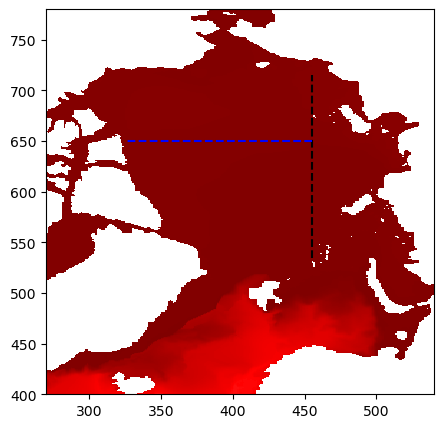

In [13]:
# plot theta with section 
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.pcolormesh(get_aste_tracer(theta[2,0,:,:],nfx,nfy)[0],cmap='seismic_r')
ax.set_xlim(270, 540)
ax.set_ylim(400, 780)
y1 = np.array([535,715])
x1 = np.array([455,455])
y2 = np.array([650,650])
x2 = np.array([455,325])
plt.plot(x1,y1,zorder=10,linestyle="dashed",color="black")
plt.plot(x2,y2,zorder=10,linestyle="dashed",color="blue")

In [14]:
# plot the two sections from theta
m = 8  # march/september
Tdata = get_aste_tracer(theta[m],nfx,nfy)
Sdata = get_aste_tracer(salt[m],nfx,nfy)

num_points = max(abs(y1[1] - y1[0]), abs(x1[1] - x1[0])) + 1
# Create linear space between the endpoints
y1_indices = np.linspace(y1[0], y1[1], num_points)
x1_indices = np.linspace(x1[0], x1[1], num_points)
y1_indices = np.round(y1_indices).astype(int)
x1_indices = np.round(x1_indices).astype(int)
z1_indices = np.arange(Tdata.shape[0])

num_points = max(abs(y2[1] - y2[0]), abs(x2[1] - x2[0])) + 1
# Create linear space between the endpoints
y2_indices = np.linspace(y2[0], y2[1], num_points)
x2_indices = np.linspace(x2[0], x2[1], num_points)
y2_indices = np.round(y2_indices).astype(int)
x2_indices = np.round(x2_indices).astype(int)
z2_indices = np.arange(Tdata.shape[0])

In [15]:
# get the distance from DXG and DYG
dx1 = get_aste_tracer(mygrid['DXG'],nfx,nfy)[0][y1_indices,x1_indices]
dy1 = get_aste_tracer(mygrid['DYG'],nfx,nfy)[0][y1_indices,x1_indices]
distances1 = np.sqrt(dx1**2 + dy1**2)
cumulative_distance1 = np.cumsum(distances1)
cumulative_distance1 /=1000 # km

dx2 = get_aste_tracer(mygrid['DXG'],nfx,nfy)[0][y2_indices,x2_indices]
dy2 = get_aste_tracer(mygrid['DYG'],nfx,nfy)[0][y2_indices,x2_indices]
distances2 = np.sqrt(dx2**2 + dy2**2)
cumulative_distance2 = np.cumsum(distances2)
cumulative_distance2 /=1000 # km

In [16]:
# Extract the cross-section along the interpolated line
cross_sectionT1 = Tdata[:, y1_indices, x1_indices]
cross_sectionS1 = Sdata[:, y1_indices, x1_indices]
XVc1,YVc1 = np.meshgrid(cumulative_distance1[::-1],mygrid['RC'])

cross_sectionT2 = Tdata[:, y2_indices, x2_indices]
cross_sectionS2 = Sdata[:, y2_indices, x2_indices]
XVc2,YVc2 = np.meshgrid(cumulative_distance2[::-1],mygrid['RC'])

In [17]:
path

'/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/'

Text(0.5, 1.0, 'Section along x')

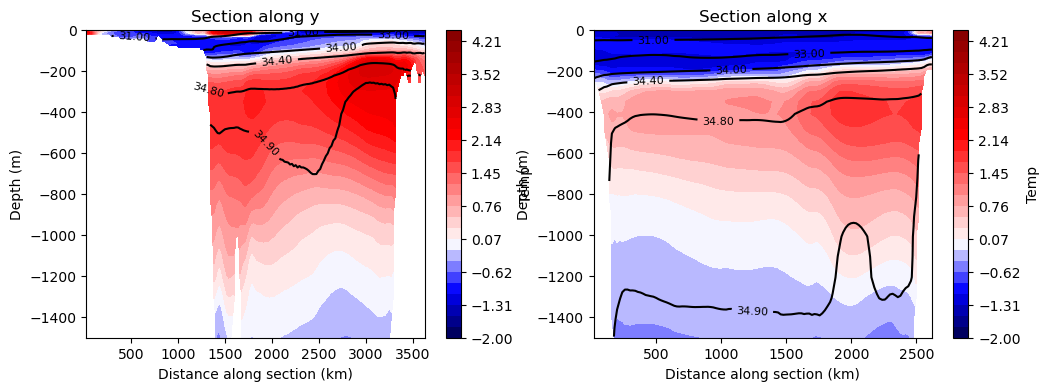

In [18]:
fig = plt.figure(figsize=(12,4))

ax = plt.subplot(121)
# Plot a contourf of the potential temperature
norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=4.5)
cb = ax.contourf(XVc1,YVc1, cross_sectionT1,cmap="seismic",levels=np.arange(-2,4.5,.23),norm=norm)  # Visualize the first layer of the 3D array
plt.colorbar(cb, extend="both",label="Temp")
ax.set_ylim(-1500,0)
# Add lines for salinity
salinity_levels = [31, 33, 34, 34.4, 34.8,34.9]
contours = ax.contour(XVc1, YVc1, cross_sectionS1, colors='black',levels=salinity_levels)
ax.clabel(contours, inline=True, fontsize=8, fmt='%.2f')
# add labels
ax.set_xlabel("Distance along section (km)")
ax.set_ylabel("Depth (m)")
ax.set_title("Section along y")

ax = plt.subplot(122)
# Plot a contourf of the potential temperature
norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=4.5)
cb = ax.contourf(XVc2,YVc2, cross_sectionT2,cmap="seismic",levels=np.arange(-2,4.5,.23),norm=norm)  # Visualize the first layer of the 3D array
plt.colorbar(cb, extend="both",label="Temp")
ax.set_ylim(-1500,0)
# Add lines for salinity
salinity_levels = [31, 33, 34, 34.4, 34.8,34.9]
contours = ax.contour(XVc2, YVc2, cross_sectionS2, colors='black',levels=salinity_levels)
ax.clabel(contours, inline=True, fontsize=8, fmt='%.2f')
# add labels
ax.set_xlabel("Distance along section (km)")
ax.set_ylabel("Depth (m)")
ax.set_title("Section along x")

In [19]:
# create the density sections and plot
p = gsw.p_from_z(mygrid['RC'],90)
# p1 = np.tile(p[:, np.newaxis], (1, cross_sectionT1.shape[1]))
# dens_section1 = gsw.rho(cross_sectionS1,cross_sectionT1,p1)
dens_section_nodepth1 = gsw.rho(cross_sectionS1,cross_sectionT1,0)
dens_section_nodepth2 = gsw.rho(cross_sectionS2,cross_sectionT2,0)

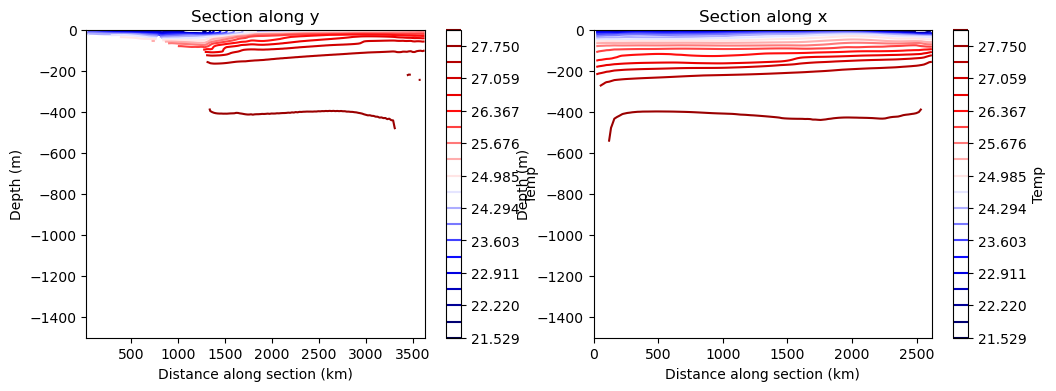

In [20]:
fig = plt.figure(figsize=(12,4))

levels = np.linspace(np.nanmin(dens_section_nodepth1 - 1000), np.nanmax(dens_section_nodepth1 - 1000), 20)

ax = plt.subplot(121)
cb = ax.contour(XVc1,YVc1, dens_section_nodepth1 - 1000,levels=levels,cmap="seismic")
plt.colorbar(cb, extend="both",label="Temp")
ax.set_ylim(-1500,0)
ax.set_xlabel("Distance along section (km)")
ax.set_ylabel("Depth (m)")
ax.set_title("Section along y")

ax = plt.subplot(122)
cb = ax.contour(XVc2,YVc2, dens_section_nodepth2 - 1000,levels=levels,cmap="seismic")
plt.colorbar(cb, extend="both",label="Temp")
ax.set_ylim(-1500,0)
ax.set_xlabel("Distance along section (km)")
ax.set_ylabel("Depth (m)")
ax.set_title("Section along x") 

plt.pcolormesh(dens_section_nodepth1 - 1000)

In [21]:
# get the m of choice from advection
ADVx_TH_sel = ADVx_TH[m]  # along-isopycnal mixing for y section
ADVy_TH_sel = ADVy_TH[m]  # along-isopycnal mixing for x section
ADVr_TH_sel = ADVr_TH[m]  # across isopycnal mixing for both sections

In [22]:
hFacC_tracer = get_aste_tracer(mygrid['hFacC'],nfx,nfy)

Text(0.5, 1.0, 'Fake isopycnal advection of TH')

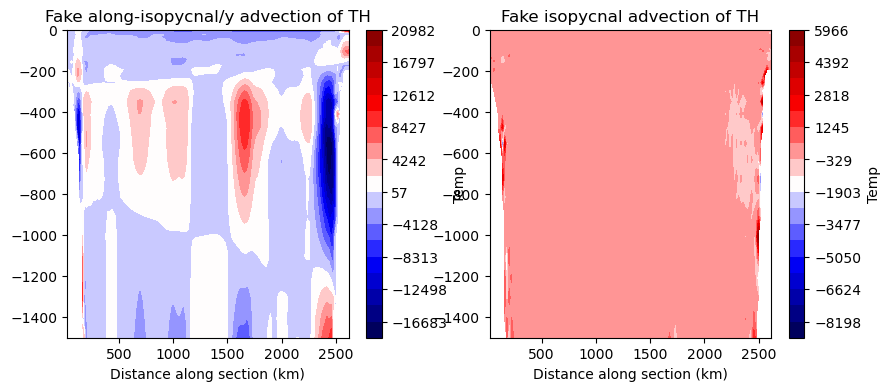

In [23]:
fig = plt.figure(figsize=(10,4))

ax = plt.subplot(121)
advy_data = get_aste_tracer(ADVy_TH_sel,nfx,nfy)[:, y2_indices, x2_indices] * hFacC_tracer[:, y2_indices, x2_indices]
cb = ax.contourf(XVc2,YVc2, advy_data,cmap="seismic",levels=np.linspace(np.nanmin(advy_data), np.nanmax(advy_data), 20))
plt.colorbar(cb, extend="both",label="Temp")
ax.set_ylim(-1500,0)
ax.set_xlabel("Distance along section (km)")
ax.set_title("Fake along-isopycnal/y advection of TH")

ax = plt.subplot(122)
advr_data1 = get_aste_tracer(ADVr_TH_sel,nfx,nfy)[:, y2_indices, x2_indices] * hFacC_tracer[:, y2_indices, x2_indices]
cb = ax.contourf(XVc2,YVc2, advr_data1,cmap="seismic",levels=np.linspace(np.nanmin(advr_data1), np.nanmax(advr_data1), 20))
plt.colorbar(cb, extend="both",label="Temp")
ax.set_ylim(-1500,0)
ax.set_xlabel("Distance along section (km)")
ax.set_title("Fake isopycnal advection of TH")

# now try to do real dia/isopycnal mixing based on the density surfaces

In [24]:
# calculate the gradient of the density
density1 = dens_section_nodepth2.copy()
d_density_dx1, d_density_dy1 = np.gradient(density1)

# Angle of the isopycnals (in radians)
# DO NOT CALL THIS THETA - THAT WOULD BE TEMPERATURE
angle1 = np.arctan2(d_density_dy1, d_density_dx1)

adv_across = advy_data * np.cos(angle1) + advr_data1 * np.sin(angle1)
adv_along = -advy_data * np.sin(angle1) + advr_data1 * np.cos(angle1)

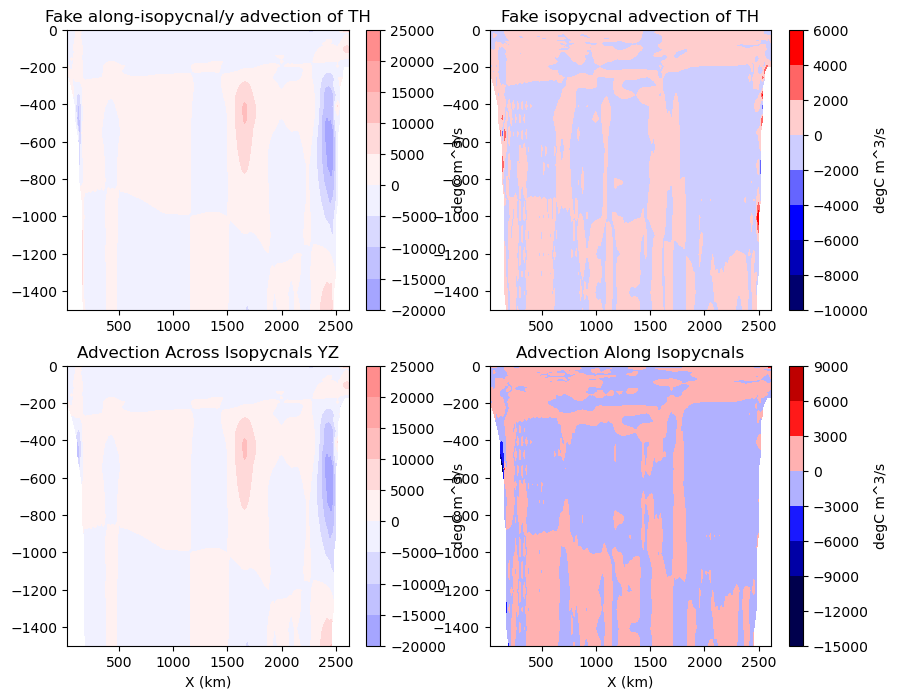

In [25]:
# plot this in comparison to the initial fake advection along/across

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
advy_data = get_aste_tracer(ADVy_TH_sel,nfx,nfy)[:, y2_indices, x2_indices] * hFacC_tracer[:, y2_indices, x2_indices]
cb = ax.contourf(XVc2,YVc2, advy_data,cmap="seismic",vmin=-100000,vmax=100000)#,levels=np.linspace(np.nanmin(advy_data), np.nanmax(advy_data), 20))
plt.colorbar(cb,label="degC m^3/s")
ax.set_ylim(-1500,0)
# ax.set_xlabel("Distance along section (km)")
ax.set_title("Fake along-isopycnal/y advection of TH")

ax = plt.subplot(222)
advr_data1 = get_aste_tracer(ADVr_TH_sel,nfx,nfy)[:, y2_indices, x2_indices] * hFacC_tracer[:, y2_indices, x2_indices]
cb = ax.contourf(XVc2,YVc2, advr_data1,cmap="seismic",vmin=-10000,vmax=10000)#,levels=np.linspace(np.nanmin(advr_data1), np.nanmax(advr_data1), 20))
plt.colorbar(cb,label="degC m^3/s")
ax.set_ylim(-1500,0)
# ax.set_xlabel("Distance along section (km)")
ax.set_title("Fake isopycnal advection of TH")

ax = plt.subplot(223)
cb = ax.contourf(XVc2,YVc2, adv_across, cmap="seismic", vmin=-100000,vmax=100000)#,levels=np.linspace(np.nanmin(adv_across), np.nanmax(adv_across), 20))
ax.set_title("Advection Across Isopycnals YZ")
plt.colorbar(cb,label="degC m^3/s")
ax.set_xlabel("X (km)")
# ax.set_ylabel("Y (km)")
ax.set_ylim(-1500,0)

ax = plt.subplot(224)
cb = ax.contourf(XVc2,YVc2, adv_along, cmap="seismic", vmin=-10000,vmax=10000)#,levels=np.linspace(np.nanmin(adv_along), np.nanmax(adv_along), 20))
ax.set_title("Advection Along Isopycnals")
plt.colorbar(cb,label="degC m^3/s")
ax.set_xlabel("X (km)")
# ax.set_ylabel("Y (km)")
ax.set_ylim(-1500,0)

plt.savefig(path + "x_comparison_isopycnal_march.png",dpi=300)

# Now try to do this for the entire domain (3D)
Need both advection in x and y

THIS IS WRONG BUT 2D is fine for now

In [26]:
# first need to calculate density for the entire domain - try to do this first and plot
thetam = theta[m]
saltm = salt[m]

In [27]:
# calculate surface-referenced density
densm = gsw.rho(saltm,thetam,0) - 1000

In [28]:
# first we calculate the density gradients in x/y/z
d_density_dx, d_density_dy, d_density_dz = np.gradient(densm)

In [29]:
# Angles of the isopycnals in the xy-plane, yz-plane, and xz-plane
angle_xy = np.arctan2(d_density_dy, d_density_dx)
angle_yz = np.arctan2(d_density_dz, d_density_dy)
angle_xz = np.arctan2(d_density_dz, d_density_dx)

In [30]:
ADVx_TH_sel = ADVx_TH[m]  # along-isopycnal mixing for y section
ADVy_TH_sel = ADVy_TH[m]  # along-isopycnal mixing for x section
ADVr_TH_sel = ADVr_TH[m]  # across isopycnal mixing for both sections

In [31]:
# Across isopycnals in the xy-plane
adv_across_xy = ADVx_TH_sel * np.cos(angle_xy) + ADVy_TH_sel * np.sin(angle_xy)

# Across isopycnals in the yz-plane
adv_across_yz = ADVy_TH_sel * np.cos(angle_yz) + ADVr_TH_sel * np.sin(angle_yz)

# Across isopycnals in the xz-plane
adv_across_xz = ADVx_TH_sel * np.cos(angle_xz) + ADVr_TH_sel * np.sin(angle_xz)

In [32]:
# Along isopycnals in the xy-plane
adv_along_xy = -ADVx_TH_sel * np.sin(angle_xy) + ADVy_TH_sel * np.cos(angle_xy)

# Along isopycnals in the yz-plane
adv_along_yz = -ADVy_TH_sel * np.sin(angle_yz) + ADVr_TH_sel * np.cos(angle_yz)

# Along isopycnals in the xz-plane
adv_along_xz = -ADVx_TH_sel * np.sin(angle_xz) + ADVr_TH_sel * np.cos(angle_xz)

(-1500.0, 0.0)

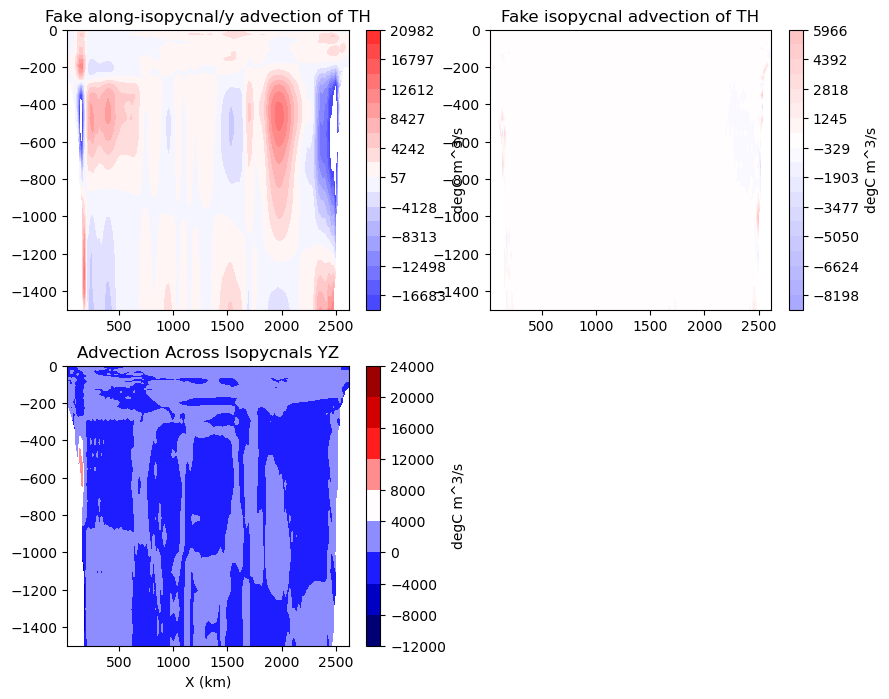

In [33]:
# compare the advection in xz to the plot from the previous fake calculation
# plot this in comparison to the initial fake advection along/across

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
advx_data = get_aste_tracer(ADVx_TH_sel,nfx,nfy)[:, y2_indices, x2_indices] * hFacC_tracer[:, y2_indices, x2_indices]
cb = ax.contourf(XVc2,YVc2, advx_data,cmap="seismic",vmin=-50000,vmax=50000,levels=np.linspace(np.nanmin(advy_data), np.nanmax(advy_data), 20))
plt.colorbar(cb,label="degC m^3/s")
ax.set_ylim(-1500,0)
# ax.set_xlabel("Distance along section (km)")
ax.set_title("Fake along-isopycnal/y advection of TH")

ax = plt.subplot(222)
advr_data1 = get_aste_tracer(ADVr_TH_sel,nfx,nfy)[:, y2_indices, x2_indices] * hFacC_tracer[:, y2_indices, x2_indices]
cb = ax.contourf(XVc2,YVc2, advr_data1,cmap="seismic",vmin=-50000,vmax=50000,levels=np.linspace(np.nanmin(advr_data1), np.nanmax(advr_data1), 20))
plt.colorbar(cb,label="degC m^3/s")
ax.set_ylim(-1500,0)
# ax.set_xlabel("Distance along section (km)")
ax.set_title("Fake isopycnal advection of TH")

ax = plt.subplot(223)
data = get_aste_tracer(adv_along_xz,nfx,nfy)
cb = ax.contourf(XVc2,YVc2, data[:,y2_indices,x2_indices], cmap="seismic")
ax.set_title("Advection Across Isopycnals YZ")
plt.colorbar(cb,label="degC m^3/s")
ax.set_xlabel("X (km)")
# ax.set_ylabel("Y (km)")
ax.set_ylim(-1500,0)

# ax = plt.subplot(224)
# cb = ax.contourf(XVc2,YVc2, adv_along, cmap="seismic", vmin=-50000,vmax=50000,levels=np.linspace(np.nanmin(adv_along), np.nanmax(adv_along), 20))
# ax.set_title("Advection Along Isopycnals")
# plt.colorbar(cb,label="degC m^3/s")
# ax.set_xlabel("X (km)")
# # ax.set_ylabel("Y (km)")
# ax.set_ylim(-1500,0)

# Let's do the binning and look at across and along isopycnal mixing

In a specific basin - ie Barents, along isopycnal mixing will be a sum of both x and y
We will take the along isopycnal mixing for each cross section in x and y and sum them
We take the across isopycnal mixing for each cross section and sum them

In [34]:
# get the number of points in the basin and we can use this as a mask for later
iB = 6
mskBarents = mskBasin.copy()
mskBarents[mskBarents != iB] = np.nan
npoints = len(np.where(mskBarents == iB)[0])   # set number of points in the basin to be used later
print(npoints)
tracer_mskBarents = get_aste_tracer(mskBarents,nfx,nfy)[0][np.newaxis,:,:]

10650


(434.0, 595.0)

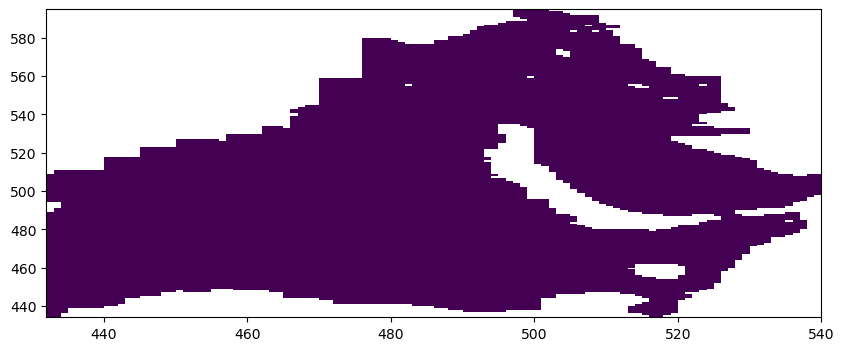

In [35]:
plt.pcolormesh(get_aste_tracer(mskBarents,nfx,nfy)[0])
plt.xlim(432,540)
plt.ylim(434,595)

In [36]:
# first need to calculate density for the entire domain - try to do this first and plot
thetam = theta[m]
saltm = salt[m]

densm = gsw.rho(saltm,thetam,0) - 1000

In [37]:
densm_tracer = get_aste_tracer(densm,nfx,nfy)

In [38]:
ADVr_TH_tracer = get_aste_tracer(ADVr_TH[m,:,:,:],nfx,nfy)

In [39]:
# create an array to store along-y isopycnal advection and along-x isopycnal advection
alongy_isopycnal_adv = np.full(densm_tracer.shape,np.nan)
alongy_diapycnal_adv = np.full(densm_tracer.shape,np.nan)

# for each x, take the section with advection in y and the section with advection in r
for x in range(428,450):
    if x%20 == 0:
        print(x)
    # get the section in y
    advy_data = (ADVy_THo[m,:,:,:] * tracer_mskBarents)[:,:,x]
    advr_data = (ADVr_TH_tracer * tracer_mskBarents)[:,:,x]
    dens_sel = (densm_tracer * tracer_mskBarents)[:,:,x]

    # do the gradient and angle calculation
    d_density_dx1, d_density_dy1 = np.gradient(dens_sel)
    angle1 = np.arctan2(d_density_dy1, d_density_dx1)

    adv_across = advy_data * np.cos(angle1) + advr_data * np.sin(angle1)
    adv_along = -advy_data * np.sin(angle1) + advr_data * np.cos(angle1)

    # set the value in the big array
    alongy_isopycnal_adv[:,:,x] = adv_along
    alongy_diapycnal_adv[:,:,x] = adv_across

440


In [40]:
# do the same for the advection in the x direction
alongx_isopycnal_adv = np.full(densm_tracer.shape,np.nan)
alongx_diapycnal_adv = np.full(densm_tracer.shape,np.nan)

# for each x, take the section with advection in y and the section with advection in r
for y in range(434,595):
    if y%20 == 0:
        print(y)
    # get the section in y
    advx_data = (ADVx_THo[m,:,:,:] * tracer_mskBarents)[:,y,:]
    advr_data = (ADVr_TH_tracer * tracer_mskBarents)[:,y,:]
    dens_sel = (densm_tracer * tracer_mskBarents)[:,y,:]

    # do the gradient and angle calculation
    d_density_dx1, d_density_dy1 = np.gradient(dens_sel)
    angle1 = np.arctan2(d_density_dy1, d_density_dx1)

    adv_across = advx_data * np.cos(angle1) + advr_data * np.sin(angle1)
    adv_along = -advx_data * np.sin(angle1) + advr_data * np.cos(angle1)

    # set the value in the big array
    alongx_isopycnal_adv[:,y,:] = adv_along
    alongx_diapycnal_adv[:,y,:] = adv_across

440
460
480
500
520
540
560
580


# Do TS binning and plot iso and diapycnal advection

In [41]:
# we now have the isopycnal and diapycnal advection due to the x and y terms
# we can bin these based on TS space
# binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = np.linspace(-3, 12, 113)
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [42]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta[m],binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt[m],binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [44]:
# Flatten the arrays to use np.add.at
# Flatten the arrays to use np.add.at
flat_binned_salinity = get_aste_tracer(binned_salinity[:,:,:],nfx,nfy).flatten()
flat_binned_salinity[np.isnan(flat_binned_salinity)] = 0
flat_binned_salinity = flat_binned_salinity.astype(int)

flat_binned_theta = get_aste_tracer(binned_theta[:,:,:],nfx,nfy).flatten()
flat_binned_theta[np.isnan(flat_binned_theta)] = 0
flat_binned_theta = flat_binned_theta.astype(int)

In [40]:
RAC3d = np.tile(get_aste_tracer(RAC,nfx,nfy)[0], (50, 1, 1))

In [45]:
# bin the advection in TH on the theta
flat_alongx_isopycnal_adv = (alongx_isopycnal_adv).flatten()          # degC m^3/s
flat_alongx_isopycnal_adv[np.isnan(flat_alongx_isopycnal_adv)] = 0

summed_alongx_isopycnal_adv = np.zeros(nT)
np.add.at(summed_alongx_isopycnal_adv, flat_binned_theta, flat_alongx_isopycnal_adv)

In [47]:
# plt.plot(binsTH_centers,summed_alongx_isopycnal_adv*1e-6,label="isopycnal adv due to ADVx")
# plt.ylabel("10^6 degC m^3/s, + into Arctic")

# I don't think it makes sense to visualize like this, I think we should look at a gate or several gates

What about just BSO

In [48]:
test = np.zeros((1350,270))
jy = [430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
        443, 444, 445, 446, 447, 448, 449, 450, 559, 559, 559, 559, 559,
        559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559,
        559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559,
        559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559]
jx = [163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163,
        163, 163, 163, 163, 163, 163, 163, 163,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42]
test[jy,jx] = 1

b = get_aste_tracer(test,nfx,nfy)[0]
np.where(b == 1)

(array([430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
        443, 444, 445, 446, 447, 448, 449, 451, 452, 453, 454, 455, 456,
        457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
        470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482,
        483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 613]),
 array([433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433,
        433, 433, 433, 433, 433, 433, 433, 430, 430, 430, 430, 430, 430,
        430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430,
        430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430,
        430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 539]))

In [50]:
# just choose where x = 432 to give a sample
bso_x_isopycnal = alongx_isopycnal_adv[:,:,433]
bso_x_diapycnal = alongx_diapycnal_adv[:,:,433]

# alongx_diapycnal_adv
bso_binned_theta = get_aste_tracer(binned_theta[:,:,:],nfx,nfy)[:,:,433].flatten()
bso_binned_theta[np.isnan(bso_binned_theta)] = 0
bso_binned_theta = bso_binned_theta.astype(int)

In [51]:
flat_bso_x_isopycnal = (bso_x_isopycnal).flatten()          # degC m^3/s
flat_bso_x_isopycnal[np.isnan(flat_bso_x_isopycnal)] = 0

summed_bso_x_isopycnal = np.zeros(nT)
np.add.at(summed_bso_x_isopycnal, bso_binned_theta, flat_bso_x_isopycnal)

flat_bso_x_diapycnal = (bso_x_diapycnal).flatten()          # degC m^3/s
flat_bso_x_diapycnal[np.isnan(flat_bso_x_diapycnal)] = 0

summed_bso_x_diapycnal = np.zeros(nT)
np.add.at(summed_bso_x_diapycnal, bso_binned_theta, flat_bso_x_diapycnal)

In [52]:
print(summed_bso_x_isopycnal.shape, bso_binned_theta.shape, flat_bso_x_isopycnal.shape)

(112,) (45000,) (45000,)


In [53]:
datetimes[m].strftime("%Y-%m")

'2014-09'

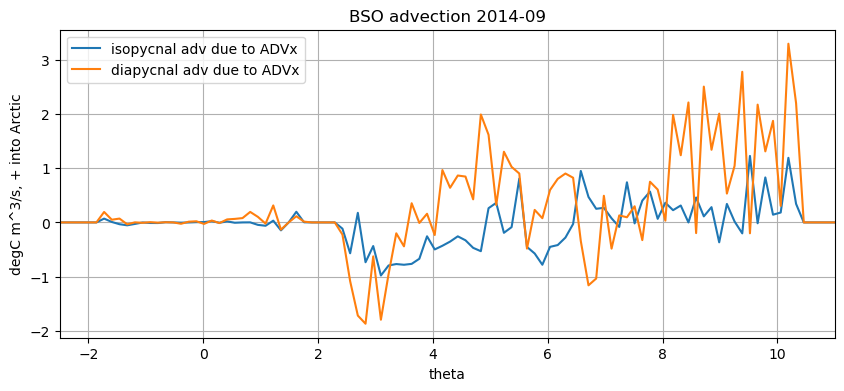

In [57]:
fig = plt.figure()

ax = plt.subplot(111)
ax.plot(binsTH_centers,summed_bso_x_isopycnal*1e-6,label="isopycnal adv due to ADVx")
ax.plot(binsTH_centers,summed_bso_x_diapycnal*1e-6,label="diapycnal adv due to ADVx")
ax.set_title("BSO advection " + datetimes[m].strftime("%Y-%m"))
ax.set_ylabel("degC m^3/s, + into Arctic")
ax.set_xlim(-2.5,11)
ax.set_xlabel("theta")
ax.grid()
ax.legend(loc="best")

plt.savefig(path + "bso_september_REALisodia.png",dpi=300)

In [58]:
# let's do a sanity check based on the vertical and horizontal advection alone
fake_bso_x_isopycnal = ADVx_THo[:,:,433]
fake_bso_x_diapycnal = (get_aste_tracer(ADVr_TH[m],nfx,nfy))[:,:,433]

# alongx_diapycnal_adv
bso_binned_theta = get_aste_tracer(binned_theta[:,:,:],nfx,nfy)[:,:,433].flatten()
bso_binned_theta[np.isnan(bso_binned_theta)] = 0
bso_binned_theta = bso_binned_theta.astype(int)

In [60]:
flat_bso_x_isopycnal = (fake_bso_x_isopycnal).flatten()          # degC m^3/s
flat_bso_x_isopycnal[np.isnan(flat_bso_x_isopycnal)] = 0

summed_bso_x_isopycnal = np.zeros(nT)
print(summed_bso_x_isopycnal.shape, bso_binned_theta.shape, flat_bso_x_isopycnal.shape)
np.add.at(summed_bso_x_isopycnal, bso_binned_theta, flat_bso_x_isopycnal)

flat_bso_x_diapycnal = (fake_bso_x_diapycnal).flatten()          # degC m^3/s
flat_bso_x_diapycnal[np.isnan(flat_bso_x_diapycnal)] = 0

summed_bso_x_diapycnal = np.zeros(nT)
np.add.at(summed_bso_x_diapycnal, bso_binned_theta, flat_bso_x_diapycnal)

(112,) (45000,) (243000,)


ValueError: array is not broadcastable to correct shape

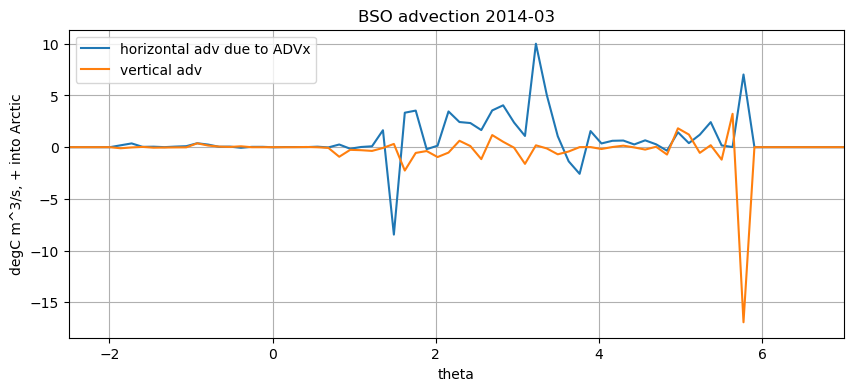

In [139]:
fig = plt.figure()

ax = plt.subplot(111)
ax.plot(binsTH_centers,summed_bso_x_isopycnal*1e-6,label="horizontal adv due to ADVx")
ax.plot(binsTH_centers,summed_bso_x_diapycnal*1e-6,label="vertical adv")
ax.set_title("BSO advection " + datetimes[m].strftime("%Y-%m"))
ax.set_ylabel("degC m^3/s, + into Arctic")
ax.set_xlim(-2.5,7)
ax.set_xlabel("theta")
ax.grid()
ax.legend(loc="best")
plt.savefig(path + "bso_march_isodia.png",dpi=300)

# great, now let's try to do across all gates to Arctic